###### Imports

Packages

In [3]:
import pandas as pd
from functions import assembleDf, epochElo, epochsElo, epochG, epochsG,PlayerElo
from datetime import datetime, timedelta
import numpy as np
import sys
sys.path.append('..')
from pyglicko2.glicko2_tests import exampleCase
from pyglicko2.glicko2 import Player
import glicko2
import time

Data

In [4]:
# read in the data that will be used with the rating systems.
matches = pd.read_csv('../Data/matches_glicko2.csv',parse_dates = 
                      ['tourney_date'], infer_datetime_format = True)

In [5]:
# read in the unfiltered data
singles_matches = pd.read_csv('../Data/singles_matches_df.csv',parse_dates = ['tourney_date'], 
                      infer_datetime_format = True)

/var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/ipykernel_53321/836863724.py:2: DtypeWarning: Columns (3,9,17) have mixed types. Specify dtype option on import or set low_memory=False.
  singles_matches = pd.read_csv('../Data/singles_matches_df.csv',parse_dates = ['tourney_date'],


###### Rating system application

In [6]:
playerClasses, ratingsHistory = epochsElo(matches)

In [69]:
ratingsHistory_df = assembleDf(ratingsHistory)

In [100]:
# fill in missing values with last seen rating.  
ratingsHistory_df = ratingsHistory_df.ffill(axis=0).fillna(1500)

In [101]:
ratingsHistory_df.columns

Int64Index([131500, 131584, 131866, 131867, 131869, 131873, 131876, 131879,
            131881, 131884,
            ...
            130340, 130355, 130457, 130493, 130542, 130550, 130552, 130553,
            130655, 130767],
           dtype='int64', length=32577)

In [102]:
# import glicko2 timestamp: (ratings, RDs) df
g2_rh= pd.read_csv('./ratings_histories_glicko2.csv', index_col = 0, parse_dates=True, dtype=np.float64)
g2_rh.columns = g2_rh.columns.astype(int)
g2_rdh = pd.read_csv('./rd_histories_glicko2.csv', index_col = 0, parse_dates=True, dtype=np.float64)
g2_rdh.columns = g2_rdh.columns.astype(int)


In [ ]:
we_le_pw = matches.apply(lambda x:
                           get_recent_rating_wp(
                               ratingsHistory_df, 
                               x['tourney_date'], 
                               x['winner_id'], 
                               x['loser_id']),
                            axis=1)

Probability calculation inspired by [chess_in_sgv](https://www.reddit.com/r/chess/comments/i0pnv1/glicko2_win_probability/) but scrapped in favor of the direct adaptation from E in step 3 of [glicko 2 example](https://www.glicko.net/glicko/glicko2.pdf) by Mark Glickman.

In [41]:
def winProbG(r1, rd1, r2, rd2):
    """Calculate the probability that player 1 defeats 
    player 2 based on Glicko2 rating and rating deviations"""
    r1 = (r1 - 1500)/173.7178
    r2 = (r2 - 1500)/173.7178
    rd1 = rd1/173.7178
    rd2 = rd2/173.7178
    rds = (rd1**2 + rd2**2)**.5
    g_phi = 1 / (1 + 3 * (rds**2) / math.pi**2)
    # x = (rd1**2 + rd2**2)
    # A = 1 / (1 + 3 * (x**2) / math.pi**2) * (r1-r2)
    E1 = 1/(1+math.e ** (-g_phi*(r1-r2)))
    return E1

In [43]:
g2_rh.index

DatetimeIndex(['1877-07-09', '1877-07-09', '1878-07-09', '1879-07-09',
               '1880-07-08', '1881-07-08', '1882-07-08', '1883-07-08',
               '1884-07-07', '1885-07-07',
               ...
               '2018-07-16', '2018-12-03', '2019-06-10', '2020-06-09',
               '2021-06-09', '2022-02-07', '2022-05-09', '2022-07-18',
               '2022-09-26', '2022-12-26'],
              dtype='datetime64[ns]', length=180, freq=None)

In [66]:
def get_recent_rating_wp(ratingsHistory_df,tourney_date,winner_id,loser_id):
    """Takes in a DataFrame of ratings history, tournament date, winner id and loser id
    and returns the winner's and loser's Elo rating as well as the win probability."""
    
    if not type(tourney_date) == pd._libs.tslibs.timestamps.Timestamp:
        tourney_date = pd.to_datetime(tourney_date)
    timestamp = max(ratingsHistory_df.index[ratingsHistory_df.index<=tourney_date])
    winner_rating, loser_rating = ratingsHistory_df.loc[timestamp,[winner_id,loser_id]]
    wp = 1/(1 + 10**((loser_rating-winner_rating)/400))
    return winner_rating, loser_rating, wp

In [78]:
ratingsHistory_df

,131500,131584,131866,131867,131869,131873,131876,131879,131881,131884,...,130340,130355,130457,130493,130542,130550,130552,130553,130655,130767
1877-07-09,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
1878-07-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1879-07-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1880-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1881-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-05,NaN,NaN,1473.301284,1580.784232,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1446.916587,NaN,NaN,NaN,1443.751284,1475.091242,NaN,NaN,1450.854843
2020-06-04,NaN,NaN,1489.892882,1574.674949,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1466.854386,NaN,NaN,1430.651881
2021-06-04,NaN,NaN,1482.284277,1564.924107,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-04,1486.770029,NaN,1457.902794,1578.157808,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1493.325776,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
def get_recent_rating_rd_wp(tourney_date, winner_id, loser_id, **kwargs):
    """Return the most recent ratings and rating deviations for the competitors as
        well as the a priori win probability for the eventual winner according to 
        the Glicko-2 rating system. **kwargs : ratingsHistory_df,rdHistory_df"""
    ratingsHistory_df = kwargs['ratingsHistory_df']
    rdHistory_df = kwargs['rdHistory_df']
    try:
        if not type(tourney_date) == pd._libs.tslibs.timestamps.Timestamp:
            tourney_date = pd.to_datetime(tourney_date)
        # for robustness, assuming that rd and ratings may have different timestamps
        timestamp_rh = max(ratingsHistory_df.index[ratingsHistory_df.index<=tourney_date])
        timestamp_rd = max(rdHistory_df.index[rdHistory_df.index<=tourney_date])
        winner_rating, loser_rating = ratingsHistory_df.loc[timestamp_rh,[winner_id,loser_id]]
        winner_rd, loser_rd = rdHistory_df.loc[timestamp_rd,[winner_id,loser_id]]
        wp = winProbG(winner_rating, winner_rd, loser_rating, loser_rd)
        return winner_rating, winner_rd, loser_rating, loser_rd, wp
    except KeyError:
        return np.nan, np.nan, np.nan, np.nan,np.nan

In [126]:
matches

,tourney_date,winner_id,loser_id,tourney_id
0,1877-07-09,113987,114149,1877-540
1,1877-07-09,113987,113999,1877-540
2,1877-07-09,113987,113963,1877-540
3,1877-07-09,113963,114158,1877-540
4,1877-07-09,113999,113953,1877-540
...,...,...,...,...
876973,2022-12-26,207987,208519,2022-M-ITF-TUN-63A-2022
876974,2022-12-26,144932,209977,2022-M-ITF-TUN-63A-2022
876975,2022-12-26,209955,209942,2022-M-ITF-TUN-63A-2022
876976,2022-12-26,209079,210696,2022-M-ITF-TUN-63A-2022


In [132]:
def wrapper_wp(x, tourney_date, winner_id, loser_id):
    return get_recent_rating_rd_wp(x[tourney_date], x[winner_id], x[loser_id])
matches.apply(wrapper_wp, axis=1, args=('tourney_date','winner_id','loser_id'))

KeyError: 'ratingsHistory_df'

In [129]:
params = {'ratingsHistory_df':g2_rh, 'rdHistory_df':g2_rdh}
wg_lg_pw = matches.apply(
               get_recent_rating_rd_wp( 
                   tourney_date, 
                   'winner_id', 
                   'loser_id',
                   **params),
                axis=1, args = ('tourney_date','winner_id','loser_id'))

NameError: name 'tourney_date' is not defined

In [125]:
params = {'ratingsHistory_df':g2_rh, 'rdHistory_df':g2_rdh}
get_recent_rating_rd_wp(tourney_date = pd.Timestamp('1877-07-09T00'),
                        winner_id = 131867,
                        loser_id = 131879,
                        **params)

(nan, nan, nan, nan, nan)

In [116]:
g2_rh.columns.shape

(25813,)

In [ ]:
131879

In [119]:
singles_matches.query('131879 == loser_id')

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
632768,2013-M-FU-EGY-34A-2013,Egypt F34,Clay,32,S,2013-11-25,15,105818,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1034.0,10.0,NaN,NaN
633332,2013-M-FU-EGY-36A-2013,Egypt F36,Clay,32,S,2013-12-09,14,122357,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1134.0,7.0,NaN,NaN
643117,2014-M-FU-EGY-17A-2014,Egypt F17,Clay,32,S,2014-05-05,11,125825,NaN,Q,...,NaN,NaN,NaN,NaN,NaN,NaN,1679.0,2.0,NaN,NaN
646775,2014-M-FU-KAZ-07A-2014,Kazakhstan F7,Hard,32,S,2014-06-16,2,111194,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,998.0,11.0,NaN,NaN
672987,2015-M-FU-EGY-17A-2015,Egypt F17,Hard,32,S,2015-05-04,16,117356,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,446.0,89.0,NaN,NaN
705887,2016-M-FU-BUL-01A-2016,Bulgaria F1,Hard,32,S,2016-05-16,12,105296,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,780.0,27.0,NaN,NaN
727004,2016-M-FU-TUN-35A-2016,Tunisia F35,Clay,32,S,2016-12-05,2,132307,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1003.0,11.0,NaN,NaN


In [121]:
params = {'ratingsHistory_df':g2_rh, 'rdHistory_df':g2_rdh}
get_recent_rating_rd_wp(tourney_date = pd.Timestamp('1877-07-09T00'),
                        winner_id = 131867,
                        loser_id = 131879,
                        ratingsHistory_df = g2_rh,
                        rdHistory_df = g2_rdh)

NameError: name 'rdHistory_df' is not defined

In [ ]:
get_recent_rating_rd_wp(g2_rh, g2_rdh ,pd.Timestamp('1877-07-09T00'),131867,131879)

In [76]:
get_recent_rating_wp(ratingsHistory_df,pd.Timestamp('1877-07-09T00'),131867,131879)

(1500.0, 1500.0, 0.5)

In [72]:
padRow = pd.DataFrame({col: 1500.0 for col in ratingsHistory_df.columns}, index = [pd.Timestamp('1877-07-09T00')])
padRow

,131500,131584,131866,131867,131869,131873,131876,131879,131881,131884,...,130340,130355,130457,130493,130542,130550,130552,130553,130655,130767
1877-07-09,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0


In [73]:
ratingsHistory_df = pd.concat([padRow,ratingsHistory_df],axis=0)

In [112]:
wg_lg_pw = matches.apply(
                           get_recent_rating_rd_wp(
                               g2_rh,g2_rdh, 
                               'tourney_date', 
                               'winner_id', 
                               'loser_id'),
                            axis=1)

ParserError: Unknown string format: tourney_date

In [110]:
singles_matches.query("loser_id == 118405 ")

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
325199,2001-M-FU-MKD-03A-2001,Macedonia F3,Hard,32,S,2001-06-25,16,103941,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,486.0,43.0,NaN,NaN


In [107]:
g2_rh.columns

Int64Index([131584, 131866, 131867, 131869, 131888, 131889, 131904, 131905,
            131910, 131911,
            ...
            129148, 129669, 129811, 129911, 129924, 130052, 130247, 130299,
            130340, 130550],
           dtype='int64', length=25813)

In [74]:
we_le_pw = matches.apply(lambda x:
                           get_recent_rating_wp(
                               ratingsHistory_df, 
                               x['tourney_date'], 
                               x['winner_id'], 
                               x['loser_id']),
                            axis=1)

KeyboardInterrupt: 

In [23]:
we_le_pw_df = pd.DataFrame.from_records(we_le_pw, columns = ['winner_elo','loser_elo','win_prob'])

In [24]:
we_le_pw_df

,winner_elo,loser_elo,win_prob
0,1500.000000,1500.000000,0.500000
1,1500.000000,1500.000000,0.500000
2,1500.000000,1500.000000,0.500000
3,1500.000000,1500.000000,0.500000
4,1500.000000,1500.000000,0.500000
...,...,...,...
876973,1520.131858,1489.986127,0.543275
876974,1510.276246,1353.839307,0.711057
876975,1416.488987,1456.834926,0.442197
876976,1522.338970,1495.882160,0.538001


In [25]:
singles_r_wp = pd.concat([singles_matches,we_le_pw_df],axis = 1)

In [26]:
singles_r_wp

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,winner_elo,loser_elo,win_prob
0,1877-540,Wimbledon,Grass,32,G,1877-07-09,19,113987,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.500000
1,1877-540,Wimbledon,Grass,32,G,1877-07-09,21,113987,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.500000
2,1877-540,Wimbledon,Grass,32,G,1877-07-09,20,113987,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.500000
3,1877-540,Wimbledon,Grass,32,G,1877-07-09,18,113963,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.500000
4,1877-540,Wimbledon,Grass,32,G,1877-07-09,17,113999,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876973,2022-M-ITF-TUN-63A-2022,M15 Monastir,Hard,32,15,2022-12-26,104,207987,6.0,NaN,...,NaN,NaN,NaN,716.0,31.0,966.0,12.0,1520.131858,1489.986127,0.543275
876974,2022-M-ITF-TUN-63A-2022,M15 Monastir,Hard,32,15,2022-12-26,103,144932,NaN,NaN,...,NaN,NaN,NaN,799.0,23.0,1117.0,8.0,1510.276246,1353.839307,0.711057
876975,2022-M-ITF-TUN-63A-2022,M15 Monastir,Hard,32,15,2022-12-26,102,209955,NaN,Q,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1416.488987,1456.834926,0.442197
876976,2022-M-ITF-TUN-63A-2022,M15 Monastir,Hard,32,15,2022-12-26,205,209079,NaN,JE,...,NaN,NaN,NaN,1125.0,7.0,1548.0,2.0,1522.338970,1495.882160,0.538001


How well does the elo prediction match with reality?

In [29]:
singles_r_wp['win_prob'].mean() # the higher elo-rated player wins %56.4 of the time


0.5641973656273931

In [38]:
singles_r_wp[singles_r_wp['tourney_level']== 'G']['win_prob'].mean() 
# In grand-slam events, the higher rated player wins 58.1% of the time

0.5808836943239509

In [ ]:
singles_r_wp[singles_r_wp['tourney_level']== 'G']

In [33]:
singles_r_wp['tourney_level'].unique()

array(['G', 'D', 'A', 'M', 'C', 'F', 'S', '15', '25'], dtype=object)

In [51]:
np.mean(singles_r_wp[(singles_r_wp['winner_rank'].isna() == False) & (singles_r_wp['loser_rank'].isna() == False)]['winner_rank'] <singles_r_wp[(singles_r_wp['winner_rank'].isna() == False) & (singles_r_wp['loser_rank'].isna() == False)]['loser_rank'])

0.64775167086075

Of the ranked matches (both players have a ranking), 64.8% of the winners have a higher ranking.

In [52]:
np.mean(singles_r_wp[(singles_r_wp['winner_rank'].isna() == False) & (singles_r_wp['loser_rank'].isna() == False)]['loser_elo'] <singles_r_wp[(singles_r_wp['winner_rank'].isna() == False) & (singles_r_wp['loser_rank'].isna() == False)]['winner_elo'])

0.6332248240479825

In [56]:
from matplotlib import pyplot as plt
import seaborn as sns

In [72]:
sns.displot(data = singles_r_wp, x = 'win_prob').set(title = 'Histogram of win_prob')

<Figure size 640x480 with 0 Axes>

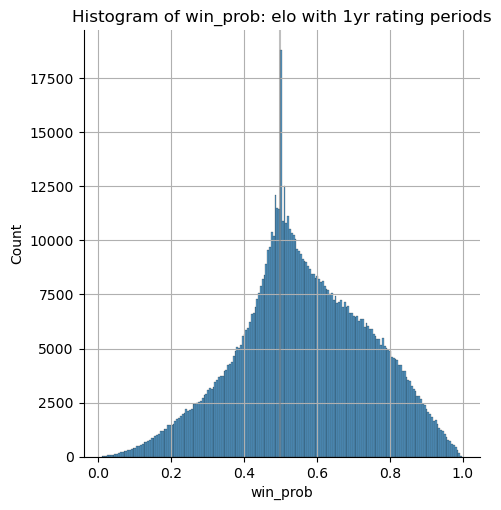

In [91]:
sns.displot(data = singles_r_wp, x = 'win_prob').set(
    title = 'Histogram of win_prob: elo with 1yr rating periods')
plt.axvline(.5,0,17500, c= 'grey', alpha = .5)
plt.grid()
plt.show()
plt.savefig('../Assets/Elo_1yr_hist',bbox_inches = 'tight')

Above we can see the distribution of win_prob for the winners.  Note the spike at win_prob = .5, which indicates the number of matches between players that had not been rated in the prior epoch and thus have the default rating of 1500.  It is promising that upon visual inspection, the number of wins with win_prob .4 is only slightly above the number of wins with win_prob of .6.  Likewise there are in the ballpark of 25% of the number of wins with a prob of .2 compared to .8.  However, there does appear to be a gradual overestimation of the win probabilities at the extreme ends of the scale.  For instance, at .9 win prob there appears to be only around 3x the number of wins as at .1 win probability.  The model is perhaps not fully picking up the true volatilities in match performance or accounting for the uncertainty of the players' mean ability.

In [92]:
singles_matches

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1877-540,Wimbledon,Grass,32,G,1877-07-09,19,113987,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1877-540,Wimbledon,Grass,32,G,1877-07-09,21,113987,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1877-540,Wimbledon,Grass,32,G,1877-07-09,20,113987,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1877-540,Wimbledon,Grass,32,G,1877-07-09,18,113963,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1877-540,Wimbledon,Grass,32,G,1877-07-09,17,113999,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876973,2022-M-ITF-TUN-63A-2022,M15 Monastir,Hard,32,15,2022-12-26,104,207987,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,716.0,31.0,966.0,12.0
876974,2022-M-ITF-TUN-63A-2022,M15 Monastir,Hard,32,15,2022-12-26,103,144932,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,799.0,23.0,1117.0,8.0
876975,2022-M-ITF-TUN-63A-2022,M15 Monastir,Hard,32,15,2022-12-26,102,209955,NaN,Q,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
876976,2022-M-ITF-TUN-63A-2022,M15 Monastir,Hard,32,15,2022-12-26,205,209079,NaN,JE,...,NaN,NaN,NaN,NaN,NaN,NaN,1125.0,7.0,1548.0,2.0


In [53]:
# check that elos are not 1500...

In [ ]:
singles_matches[1:10].shape,matches[1:10].shape

In [ ]:
matches.dtypes

In [ ]:
testDf

In [ ]:
matches[1:10].apply(
    lambda x: get_recent_rating_wp(ratingsHistory_df, x['tourney_date'], 
                                   x['winner_id'], x['loser_id']),axis=1)

In [ ]:
testDf['winner_elo','loser_elo','predicted_wins'] = matches[1:10].apply(
    lambda x: get_recent_rating_wp(ratingsHistory_df, x['tourney_date'], 
                                   x['winner_id'], x['loser_id']),axis=1)

In [ ]:
testDf = singles_matches[1:10]
testDf['winner_elo','loser_elo','predicted_wins'] = matches[1:10].apply(
    lambda x: get_recent_rating_wp(ratingsHistory_df, x['tourney_date'], 
                                   x['winner_id'], x['loser_id']),axis=1)


In [ ]:
[1,2,3][0:-1]

In [ ]:
ratingsHistory_df

In [ ]:
singles_matches

In [ ]:
ratingsHistory_df.columns

In [ ]:
set(list(matches['winner_id'].unique()) + list(matches['loser_id'].unique()))

In [ ]:
set(ratingsHistory_df) - 

In [ ]:
singles_matches[['winner_elo','loser_elo','predicted_wins']] = matches[['tourney_date','winner_id','loser_id']].apply(lambda x: 
get_recent_rating_wp(ratingsHistory_df, x['tourney_date'], x['winner_id'], x['loser_id']),axis=1)

In [ ]:
ratingsHistory_df